In [1]:
# FOR COLAB
# ! gdown https://drive.google.com/uc?id=1z687TgOTdV5j-JX0Nuw37uUVO3twX8U5
# ! unzip my_midv500_compressed.zip   
# from google.colab import drive
# drive.mount('/content/drive')
# -- download 
# import gdown deeplab_0.0064 checkpoint
# gdown.download("https://drive.google.com/uc?id=1--MVFslCY6NZ0yIfAyl_I97i6Hyzd0Ce", 'deeplab_0.0064.pth', quiet=False)


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import pickle
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from random import choice, randint
import cv2
import torchvision.models.segmentation
import torch
import torchvision.transforms as tf
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models.segmentation import deeplabv3_resnet50
from tqdm.notebook import tqdm

lr = 1e-5
width, height = 450, 800 # image width and height
batch_size = 3
out_channels = 2

test_folder = "my_midv500_compressed/test/"
train_folder = "my_midv500_compressed/train/"


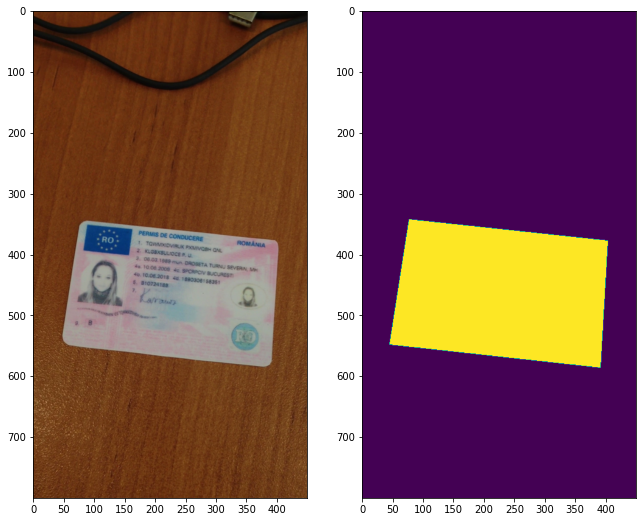

In [2]:
phase = 'train'
ann_file_lines = open(f'my_midv500_compressed/{phase}/ann_file.txt', 'rt').readlines()
ann_file_lines = [line.strip() for line in ann_file_lines]
ann_file_lines = [line.split(' ', 1) for line in ann_file_lines]
ann_file_lines = [(name, [int(el) for el in arr.split()]) for name, arr in ann_file_lines]
ann_file_lines = {name : [[arr[i], arr[i+1]] for i in range(0, 8, 2) ] for name, arr in ann_file_lines}
name = choice(list(ann_file_lines.keys()))
img = cv2.imread((test_folder if phase == 'test' else train_folder) + name)
ann_map = np.zeros(img.shape[0:2], np.float32)
poly = ann_file_lines[name]
f, axarr = plt.subplots(1,2, figsize=(9*1.2, 8*1.2)) #,dpi=150,fontsize=1)
axarr[0].imshow(img[:,:,::-1])
cv2.fillPoly(ann_map, np.array([poly]), 1)
axarr[1].imshow(ann_map)
plt.show()

In [3]:
class Task1Dataset(Dataset):
    def __init__(self, imgs_folder: str, transform_img=None, transform_ann=None, ann_file_name='ann_file.txt'):
        self._transform_img = transform_img
        self._transform_ann = transform_ann
        self.imgs_folder = imgs_folder
        # читаем файл с описанием 
        ann_file_lines = open(f'{imgs_folder}/{ann_file_name}', 'rt').readlines()
        # разделяем строчки на имя картинки и массив 
        ann_file_lines = [line.strip().split(' ', 1) for line in ann_file_lines]
        # проверяем что имена картинок уникальны
        names_from_ann_file = [name for name, _ in ann_file_lines]
        assert len(names_from_ann_file) == len(set(names_from_ann_file))
        # приводим числа в массиве к инту
        ann_file_lines = [(name, [int(el) for el in arr.split()]) for name, arr in ann_file_lines]
        # проверяем размер массива и тип 
        arrs_fron_ann_file = [arr for _, arr in ann_file_lines]
        for arr in arrs_fron_ann_file:
            assert isinstance(arr, list)
            assert len(arr) == 8
        # преобразуем массив в список пар и создаем словарь
        ann_file_dict =  {name : [[arr[i], arr[i+1]] for i in range(0, 8, 2) ] for name, arr in ann_file_lines}
        self.list_img_names = list(ann_file_dict.keys())
        self.name_to_poly = ann_file_dict
        #  провяем что все размеры совпали
        assert len(self.name_to_poly) == len(self.list_img_names) == len(names_from_ann_file)
        # загружаем названия картинок из папки и проверяем что они такие же как в ann_file
        list_images = [filename for filename in os.listdir(imgs_folder) if filename != ann_file_name]
        assert len(list_images) == len(set(list_images)) == len(self.name_to_poly)
        assert set(list_images) == set(self.list_img_names)

    def __len__(self):
        return len(self.name_to_poly)

    def get_all_info(self, idx):
        assert isinstance(idx, int)
        name = self.list_img_names[idx]
        # читаем картинку из папки
        img = cv2.imread(self.imgs_folder + name)[:,:,0:3]
        assert img.shape == (800, 450, 3)
        img = np.array(img)
        # заполняем маску единичками
        ann_map = np.zeros(img.shape[0:2], np.float32)
        poly = self.name_to_poly[name]
        cv2.fillPoly(ann_map, np.array([poly]), 1)
        
        # запоминаем сырые данные
        raw_img = img
        raw_ann = ann_map
        
        # применяем трансорфмации
        assert self._transform_ann is not None
        assert self._transform_img is not None
        img = self._transform_img(img)
        ann_map = self._transform_ann(ann_map)

        return img, ann_map, name, raw_img, raw_ann, poly
    
    def __getitem__(self, idx):
        assert isinstance(idx, int)
        name = self.list_img_names[idx]
        # читаем картинку из папки
        img = cv2.imread(self.imgs_folder + name)[:,:,0:3]
        assert img.shape == (800, 450, 3)
        
        # заполняем маску единичками
        ann_map = np.zeros(img.shape[0:2], np.float32)
        poly = self.name_to_poly[name]
        cv2.fillPoly(ann_map, np.array([poly]), 1)

        # применяем трансорфмации
        assert self._transform_ann is not None
        assert self._transform_img is not None
        img = self._transform_img(img)
        ann_map = self._transform_ann(ann_map)

        return img, ann_map, name

# Transform image
transformImg = tf.Compose([
    tf.ToPILImage(),
    tf.Resize((height, width)),
    tf.ToTensor(),
    tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transformAnn = tf.Compose([
    tf.ToPILImage(),
    tf.Resize((height, width), tf.InterpolationMode.NEAREST),
    tf.ToTensor()
])

full_train_dataset = Task1Dataset(train_folder, transformImg, transformAnn)
test_dataset = Task1Dataset(test_folder, transformImg, transformAnn)

train_size = int(0.85 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2) 
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0) 

datasets = {
    'train': train_dataset,
    'val': val_dataset
}

data_loaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

In [4]:
transformImg(test_dataset[0][0]).shape

torch.Size([3, 800, 450])

In [5]:
# Load and set net and optimizer-------------------------------------
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
assert torch.cuda.is_available()
print(device)

# Load net
Net = deeplabv3_resnet50(pretrained=True) 

# Change final layer to 2 classes
Net.classifier[4] = torch.nn.Conv2d(256, out_channels, kernel_size=(1, 1), stride=(1, 1))
Net = Net.to(device)
optimizer = torch.optim.Adam(params=Net.parameters(), lr=lr)

cuda


In [6]:
Net.load_state_dict(torch.load('task1_deeplab_v1_checks/epoch_13_val_0.00344.pth'))
_ = Net.eval()

In [7]:
# TRAIN LOOP
# criterion = torch.nn.CrossEntropyLoss() 

# # Training loop
# for epoch in range(100):
#     itr = 0
#     running_loss = {
#         'train': 0.0,
#         'val': 0.0
#     }
#     for phase in ['train', 'val']:
#         if phase == 'train':
#             Net.train() 
#         else:
#             Net.eval() 

#         for images, ann, names in tqdm(data_loaders[phase]): 
#             ann = torch.squeeze(ann)
#             itr += 1
#             images = images.to(device)
#             ann = ann.to(device)
            
#             optimizer.zero_grad()

#             with torch.set_grad_enabled(phase == 'train'):
            
#                 Pred = Net(images)['out'] 
#                 Loss = criterion(Pred, ann.long()) 
                
#                 if phase == 'train':
#                     Loss.backward() 
#                     optimizer.step() 

#             loss_numpy = Loss.data.cpu().numpy()
#             if (itr - 1) % 40 == 0:
#                 print(f"{epoch}.{itr}) Loss = {loss_numpy:.4f}", sep='')
#             running_loss[phase] += loss_numpy * len(images)
        
#         running_loss[phase] /= len(datasets[phase])
    
#     torch.save(Net.state_dict(), f"task1_deeplab_v1_checks/epoch_{epoch+2}_val_{running_loss['val']:.5f}.pth")

#     for key, value in running_loss.items():
#         print(f'Epoch {epoch}, {key} loss = {value:.4f}')

In [7]:
from shapely import geometry
from scipy.spatial import distance as dist


def order_points(pts):
    xSorted = pts[np.argsort(pts[:, 0]), :]
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]
    return [list(tl), list(tr), list(br), list(bl)]

def iou_relative_quads(quad1, quad2):
    """
    Вычисляет Intersection over Union между двумя четырехугольниками.
    Четырехугольники должны быть представлены в относительном масштабе [0..1].
    В вычислении IoU учитывается только площадь в пределах значений [0..1].
    """
    quad1 = geometry.Polygon(quad1)
    quad2 = geometry.Polygon(quad2)

    # IoU вычисляется только в рамках кадра
    frame = geometry.Polygon([
        [0, 0],
        [0, 1],
        [1, 1],
        [1, 0]
    ])
    if not (quad1.is_valid and quad2.is_valid):
        if not quad1.is_valid:
            pass
#             print('quad1 is not valid')
        if not quad2.is_valid:
            pass
#             print('quad2 is not valid')

        return 0.0
    try:
        return (quad1 & quad2 & frame).area  / ((quad1 | quad2) & frame).area
    except Exception as exc:
        return 0.0

In [8]:
# НЕ ИСПОЛЬЗУЕТСЯ
# Один из вариантов предсказания углов по маске

# # idx = randint(0, len(test_dataset) - 1)
# ious = []
# for idx in tqdm(range(len(test_dataset))):
#     try:
#         img, ann_map, name, raw_img, raw_ann, poly = test_dataset.get_all_info(idx)

# #         f, axarr = plt.subplots(1,3, figsize=(9*1.6, 8*1.6))
# #         axarr[0].imshow(raw_img[:,:,::-1])

#         with torch.no_grad():
#             Prd = Net(img.unsqueeze(0).to(device))['out']

#         seg = torch.argmax(Prd[0], 0).cpu().detach().numpy()  # Get predicted classes
#         seg = np.pad(seg, pad_width=20)
#     #     axarr[1].imshow(seg)

#         corners = cv2.goodFeaturesToTrack(np.uint8(seg), maxCorners=4, qualityLevel=0.05, minDistance=200).squeeze()

#     #     axarr[2].imshow(raw_ann)

#         for corner in corners:
#             point_size = 70
# #             axarr[1].scatter([corner[0]], [corner[1]], alpha=0.5, s=point_size)
#             corner[0] -= 20
#             corner[1] -= 20
#     #         axarr[2].scatter([corner[0]], [corner[1]], alpha=0.5, s=point_size)

#     #     print(poly)
#         corners = order_points(corners)

#         div_poly = [[x/450,y/800] for x,y in poly]
#         div_corners = [[x/450,y/800] for x,y in corners]
#         iou = iou_relative_quads(div_poly, div_corners)
#         ious.append(iou)
#         if idx % 50 == 0:
#             ious_len = len(ious)
#             ious_good_len = len([cur_iou for cur_iou in ious if cur_iou > 0.95])
#             print(idx, ious_good_len, ious_len, f'{ious_good_len/ious_len:.2f}')
#     #     print(f'{iou:.3f}')

#     #     plt.show()
#     except:
#         continue


## Тренируем регрессию на масках

In [16]:
# # Здесь создаем предсказание для каждой фотографии в трейне

# pred_masks = []
# true_polygons = []
# names = []

# # pickle.dump( (pred_masks, true_polygons, names), open( "train_masks_poly_names.p", "wb" ) )

# for idx in tqdm(range(len(full_train_dataset))):
#     img, ann_map, name, raw_img, raw_ann, poly = full_train_dataset.get_all_info(idx)

#     with torch.no_grad():
#         Prd = Net(img.unsqueeze(0).to(device))['out']

#     seg = torch.argmax(Prd[0], 0).cpu().detach().numpy()  # Get predicted classes
#     pred_masks.append(seg)
#     true_polygons.append(poly)
#     names.append(name)

# # pickle.dump( (pred_masks, true_polygons, names), open( "train_masks_poly_names.p", "wb" ) )

    

In [9]:
# !mkdir task1_reg_from_mask_checks_v2

In [10]:
def train_reg_model(model, dataloaders, criterion, optimizer, num_epochs=25, version=2, start_epoch=0):
    epoch_loss = 0
    for epoch in range(num_epochs):
        dirname = 'task1_reg_from_mask_checks_v2'
        torch.save(model.state_dict(),\
                f'{dirname}/epoch_{epoch+start_epoch}_v{version}_eploss_{epoch_loss}.pth'
        )
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 
            running_loss = 0.0

            for inputs, labels, names in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)

                labels = labels.to(torch.float32)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

        print()

    return model
            
def initialize_model(model_name, num_classes, use_pretrained=True, unfreeze_from=None, img_channels=3):
    model_ft = None
    input_size = 0

    assert model_name == "resnet"
    model_ft = torchvision.models.resnet18(pretrained=use_pretrained)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    if img_channels != 3:
        print(f'set conv1: {nn.Conv2d(img_channels, model_ft.inplanes, kernel_size=7, stride=2, padding=3, bias=False)}')
        model_ft.conv1 = nn.Conv2d(img_channels, model_ft.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
    # input_size = 224
    input_size = None

    return model_ft, input_size

from torch.utils.data import Dataset
from torchvision.io import read_image
import os.path as osp


class TaskRegDataset(Dataset):
    def __init__(self, pred_masks:list, true_polygons:list, names:list):
        self.pred_masks = pred_masks
        self.true_polygons = true_polygons
        self.names = names
        assert len(pred_masks) == len(true_polygons) == len(names)
        assert len(true_polygons) > 0
        assert isinstance(true_polygons, list)
        assert isinstance(true_polygons[-1], list)
        assert len(true_polygons[-1]) == 4
    
    def __len__(self):
        return len(self.pred_masks)

    def __getitem__(self, idx):
        assert isinstance(idx, int)
        
        pred_mask, true_polygon, name = \
            self.pred_masks[idx], self.true_polygons[idx], self.names[idx]
        
        new_mask = np.zeros(shape=(3, pred_mask.shape[0], pred_mask.shape[1]))
        new_mask[0] = pred_mask.copy()

        
        return torch.Tensor(new_mask), torch.FloatTensor(true_polygon).flatten(), name
    
# train_prefix = 'masks_for_train_imgs/'
# test_prefix = 'my_midv500_compressed/test/'

train_dataset_reg = TaskRegDataset(
    pred_masks, true_polygons, names
)

batch_size = 4
train_size_reg = int(0.9 * len(train_dataset_reg))
val_size_reg = len(train_dataset_reg) - train_size_reg
train_dataset_reg, val_dataset_reg = random_split(train_dataset_reg, [train_size_reg, val_size_reg])

train_dataloader_reg = DataLoader(train_dataset_reg, batch_size=batch_size, shuffle=True, num_workers=2) 
val_dataloader_reg = DataLoader(val_dataset_reg, batch_size=batch_size, shuffle=True, num_workers=2) 

datasets = {
    'train': train_dataset_reg,
    'val': val_dataset_reg
}

data_loaders = {
    'train': train_dataloader_reg,
    'val': val_dataloader_reg
}


In [11]:
# создаем модель для регрессии

num_classes = 8 

model_ft, _ = \
    initialize_model("resnet", num_classes, use_pretrained=True, img_channels=3)

device = 'cuda'
model_ft = model_ft.to(device)

optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [12]:
criterion = nn.MSELoss()
num_epochs = 150

# тренируем регресионную модель
# final_model = train_reg_model(model_ft, data_loaders, criterion, optimizer_ft, num_epochs=num_epochs)

In [13]:
# загружаем сохраненную модель 
model_ft.load_state_dict(torch.load('task1_reg_from_mask_checks_v2/epoch_114_v2_eploss_365.400518245697.pth'))


<All keys matched successfully>

In [15]:
# idx = randint(0, len(test_dataset) - 1)
SHOW = False
ious = []
for idx in tqdm(range(len(test_dataset))):
    img, ann_map, name, raw_img, raw_ann, poly = test_dataset.get_all_info(idx)
    with torch.no_grad():
        Prd = Net(img.unsqueeze(0).to(device))['out']
    pred_mask = torch.argmax(Prd[0], 0).cpu().detach().numpy()
    if SHOW:
        f, axarr = plt.subplots(1,3, figsize=(9*1.6, 8*1.6))
        axarr[0].imshow(raw_img[:,:,::-1])
        axarr[1].imshow(pred_mask)
        axarr[2].imshow(raw_ann)
        print(poly)

    div_poly = [[x/450,y/800] for x,y in poly]

    new_mask = np.zeros(shape=(3, pred_mask.shape[0], pred_mask.shape[1]))
    new_mask[0] = pred_mask.copy()
    with torch.no_grad():
        reg_result = model_ft(torch.FloatTensor(new_mask).unsqueeze(0).to(device)).detach().cpu().numpy()[0]
    if SHOW:
        print(reg_result)
    
    for plt_num in range(1, 3):
        if SHOW:
            axarr[plt_num].scatter([reg_result[i] for i in range(0,8,2)], [reg_result[i] for i in range(1,8,2)], c='red', s=60, alpha=0.5)

    div_reg_result = [[reg_result[i] / 450, reg_result[i+1] / 800] for i in range(0,8,2)]
    if SHOW:
        print(f'{iou_relative_quads(div_poly, div_reg_result):.3f}')
    if SHOW:
        plt.show()
    iou = iou_relative_quads(div_poly, div_reg_result)
    ious.append(iou)
    if idx % 100 == 0:
        ious_good = [cur_iou for cur_iou in ious if cur_iou > 0.95]
        print(f'{len(ious_good) / len(ious):.2f}', len(ious), len(ious_good), idx)




  0%|          | 0/4250 [00:00<?, ?it/s]

1.00 1 1 0
0.85 101 86 100
0.89 201 178 200
0.84 301 252 300
0.81 401 324 400
0.82 501 411 500
0.80 601 478 600
0.80 701 562 700
0.78 801 626 800
0.78 901 700 900
0.76 1001 760 1000
0.77 1101 848 1100
0.77 1201 925 1200
0.78 1301 1010 1300
0.79 1401 1103 1400
0.78 1501 1178 1500
0.79 1601 1271 1600
0.79 1701 1352 1700
0.79 1801 1426 1800
0.79 1901 1508 1900
0.79 2001 1590 2000
0.79 2101 1665 2100
0.79 2201 1736 2200
0.79 2301 1827 2300
0.78 2401 1872 2400
0.78 2501 1946 2500
0.77 2601 2003 2600
0.77 2701 2087 2700
0.77 2801 2144 2800
0.74 2901 2157 2900
0.73 3001 2205 3000
0.73 3101 2264 3100
0.72 3201 2317 3200
0.73 3301 2400 3300
0.73 3401 2495 3400
0.74 3501 2585 3500
0.74 3601 2653 3600
0.74 3701 2727 3700
0.74 3801 2809 3800
0.74 3901 2895 3900
0.74 4001 2976 4000
0.75 4101 3060 4100
0.75 4201 3138 4200


## Тестируем


In [19]:
from pathlib import Path
from course_ocr_t1.data import MidvPackage
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
from random import randint
from shutil import copyfile
import PIL

DATASET_PATH = Path() / 'midv500_compressed'
assert DATASET_PATH.exists()
assert DATASET_PATH.absolute()

data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)


In [ ]:
results_dict = dict()

for dp in tqdm(data_packs):
        for i in range(len(dp)):
            if dp[i].is_test_split():
                dpi = dp[i]
                img = transformImg(np.asarray(PIL.Image.open(dpi.img_path)))
                with torch.no_grad():
                    Prd = Net(img.unsqueeze(0).to(device))['out']
                pred_mask = torch.argmax(Prd[0], 0).cpu().detach().numpy()
                new_mask = np.zeros(shape=(3, pred_mask.shape[0], pred_mask.shape[1]))
                new_mask[0] = pred_mask.copy()
                with torch.no_grad():
                    reg_result = model_ft(torch.FloatTensor(new_mask).unsqueeze(0).to(device)).detach().cpu().numpy()[0]
                div_reg_result = [[reg_result[i] / 450, reg_result[i+1] / 800] for i in range(0,8,2)]
                iou = iou_relative_quads(dpi.quadrangle, div_reg_result)
                # print(iou)
                results_dict[dp[i].unique_key] = div_reg_result
            

 68%|██████▊   | 34/50 [12:22<10:37, 39.85s/it]

In [21]:
len(results_dict)

4250

In [22]:
from course_ocr_t1.metrics import dump_results_dict, measure_crop_accuracy

dump_results_dict(results_dict, Path() / 'pred.json')

acc = measure_crop_accuracy(
    Path() / 'pred.json',
    Path() / 'gt.json'
)

acc

0.724